# Load pre-saved max/min images + create figures


In [5]:
# Visualize maximally activating images for a given neuron
import matplotlib.pyplot as plt

import os
import pandas as pd

import numpy as np

In [6]:

# Load global layer max and min activations
def load_max_and_min_per_layer(layer_num, save_path=f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/',z_score=True):
    # Load df
    file_name = f'mlp_fc1_{layer_num}.npz'
    loaded = pd.read_parquet(os.path.join(save_path, file_name))

    # Calculate mean and standard deviation for 'activation_value' grouped by 'neuron_idx'
    grouped = loaded.groupby('neuron_idx')['activation_value']
    mean_per_neuron = grouped.transform('mean')
    std_dev_per_neuron = grouped.transform('std')

    # Calculate the z-score (number of standard deviations from the mean)
    loaded['activation_value_sds'] = (loaded['activation_value'] - mean_per_neuron) / std_dev_per_neuron

    # Replace NaN and infinite values (which can occur if std_dev is zero) with zero
    loaded['activation_value_sds'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    # Sort by z-score

    if z_score:
        sorted_df = loaded.sort_values(by=['activation_value_sds'], ascending=False)
    else:
        sorted_df = loaded.sort_values(by=['activation_value'], ascending=False)
    return sorted_df

# Load 10 max and 10 min images for a given neuron
def load_min_and_max_imgs_per_neuron(layer_num, neuron_num, directory):
    max_neuron_csv = os.path.join(directory, f'max_imgs_neuron_{neuron_num}.csv')
    min_neuron_csv = os.path.join(directory, f'min_imgs_neuron_{neuron_num}.csv')
    # Open csv and turn to pandas df
    max_df = pd.read_csv(max_neuron_csv)
    min_df = pd.read_csv(min_neuron_csv)
    return max_df, min_df



In [7]:
import pandas as pd


def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

    activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

    # Plotting the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1,2,0))
    ax.imshow(heatmap, cmap='viridis', alpha=0.4)  # Overlaying the heatmap

    # Removing axes
    ax.axis('off')

    min_activation = activation_values_array.min()
    max_activation = activation_values_array.max()

    # Adding colorbar for the heatmap
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

    plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
    plt.show()




## Visualize 10 images per max/min neuron per layer

Do this for 10 max/min neurons.

  0%|          | 0/10 [00:00<?, ?it/s]

on neuron 792


FileNotFoundError: [Errno 2] No such file or directory: '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/max_min_imgs/layer_0/neuron_792_max_0.svg'

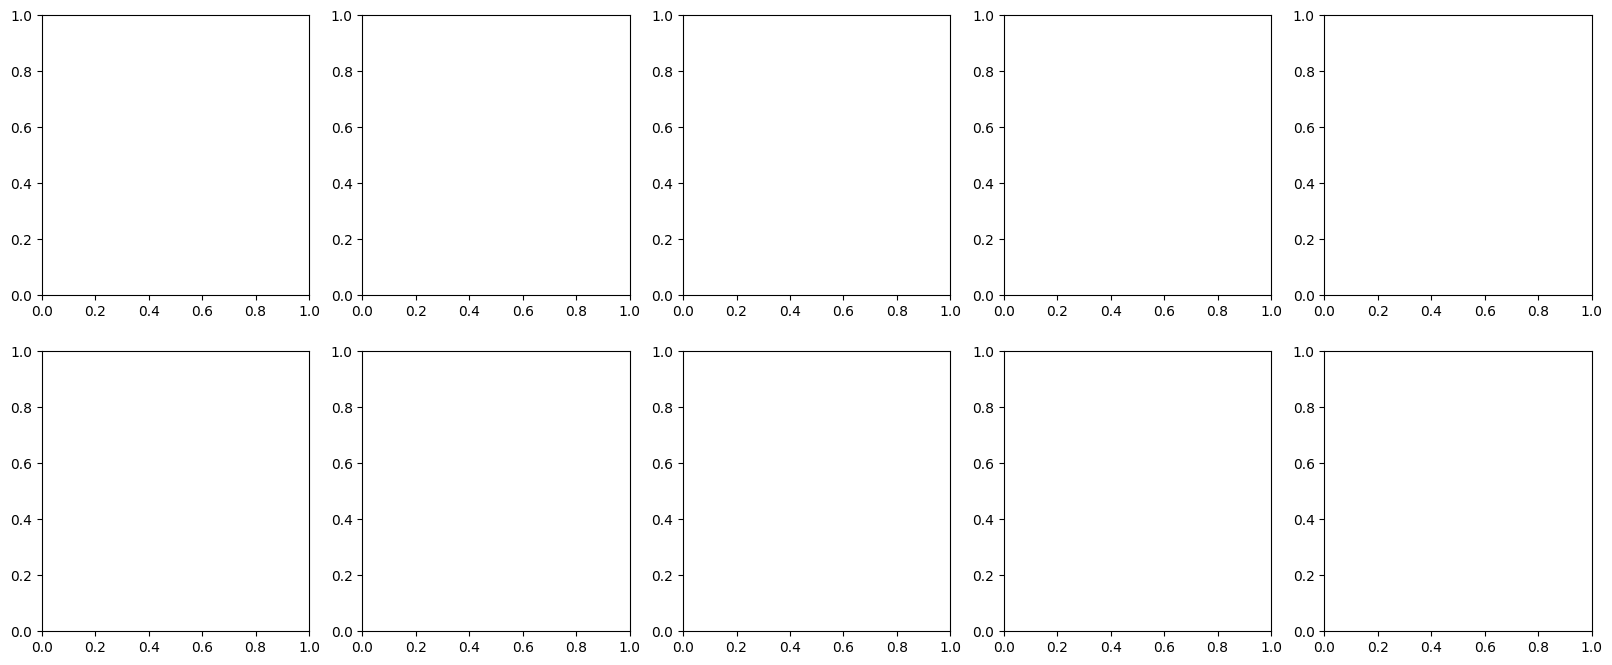

In [10]:
from tqdm.notebook import tqdm
import cairosvg

SVG = True

for layer_num in tqdm(range(0, 10)):
    df = load_max_and_min_per_layer(layer_num, z_score=True) # You can sort by SD or by raw activation_value. Not clear which one is more interpretable.

    # Get 10 max/min neurons. Get 10 max/min images for each neuron.
    max_neurons = df.drop_duplicates(subset='neuron_idx', keep='first').head(10)
    min_neurons = df.drop_duplicates(subset='neuron_idx', keep='last').tail(10)

    save_directory = '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/figures/max_min_figures'
    save_directory = os.path.join(save_directory, f'layer_{layer_num}')

    # Make directory if doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    load_directory = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/max_min_imgs/layer_{layer_num}'

    # Iterate through top/bottom neurons b
    for name, neuron_type in zip(["max", "min"], [max_neurons, min_neurons]):
        for idx, neuron_idx in enumerate(neuron_type['neuron_idx']):
            print("on neuron", neuron_idx)
            # Create a new figure for each neuron
            fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust the size as needed

            # Flatten the array of axes for easy iterating
            axs = axs.flatten()

            # Iterate through images for neuron
            for img_idx, ax in enumerate(axs): 
                # Load image
                max_img_path = os.path.join(load_directory, f'neuron_{neuron_idx}_{name}_{img_idx}.svg')
                if SVG:
                    cairosvg.svg2png(url=max_img_path, write_to='output.png')
                else:
                    max_img = plt.imread(max_img_path)

                # Display image
                ax.imshow(max_img)
                ax.axis('off')  # Turn off axis

            # Add a master title for the figure
            plt.suptitle(f'Neuron {neuron_idx} - Top 10 Images', fontsize=16)

            # Adjust layout and display the figure
            plt.tight_layout()
            plt.subplots_adjust(top=1)  # Adjust the top so that the suptitle does not overlap with the subplots
        
            # Save the figure as an SVG file
            save_path = os.path.join(save_directory, f'{idx}-{name}-neuron_{neuron_idx}_10_images.svg')
            plt.savefig(save_path, format='svg')
            save_path = os.path.join(save_directory, f'{idx}-{name}-neuron_{neuron_idx}_10_images.png')
            plt.savefig(save_path, format='png')

            # Close the figure to free memory
            plt.close(fig)
        


UnidentifiedImageError: cannot identify image file '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/max_min_imgs/layer_7/neuron_128_max_0.svg'

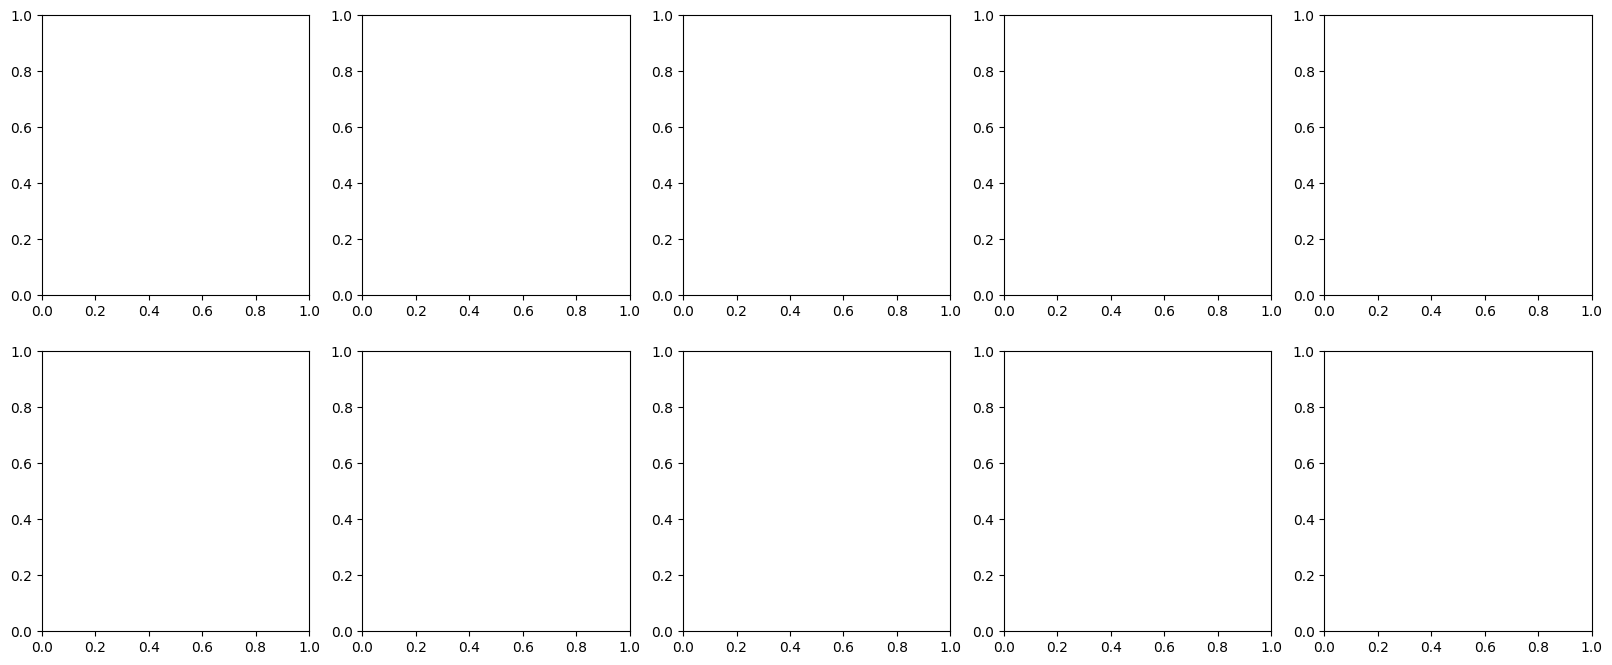

In [12]:
# Get some neurons automatically
layer_num = 7
subset_neurons = [128, 9, 534, 469, 590]
load_directory = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/max_min_imgs/layer_{layer_num}'
save_directory = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/figures/select_figures/layer_{layer_num}'

# if directory doesn't exist, make it
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

name = 'max'
for neuron_idx in subset_neurons:
    # Create a new figure for each neuron
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust the size as needed

    # Flatten the array of axes for easy iterating
    axs = axs.flatten()

    # Iterate through images for neuron
    for img_idx, ax in enumerate(axs): 
        # Load image
        max_img_path = os.path.join(load_directory, f'neuron_{neuron_idx}_{name}_{img_idx}.svg')
        max_img = plt.imread(max_img_path)

        # Display image
        ax.imshow(max_img)
        ax.axis('off')  # Turn off axis

    # Add a master title for the figure
    plt.suptitle(f'Neuron {neuron_idx} - Top 10 Images', fontsize=16)

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.subplots_adjust(top=1)  # Adjust the top so that the suptitle does not overlap with the subplots

    # Save the figure as an SVG file
    save_path = os.path.join(save_directory, f'{name}-neuron_{neuron_idx}_10_images.svg')
    plt.savefig(save_path, format='svg')
    save_path = os.path.join(save_directory, f'{name}-neuron_{neuron_idx}_10_images.png')
    plt.savefig(save_path, format='png')

    # Close the figure to free memory
    plt.close(fig)

## Visualize max/min 10 images per random neuron per layer

Get rough read on % that is:
* Interpretable
* Polysemantic

  0%|          | 0/10 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/max_min_imgs/layer_0/neuron_788_max_0.svg'

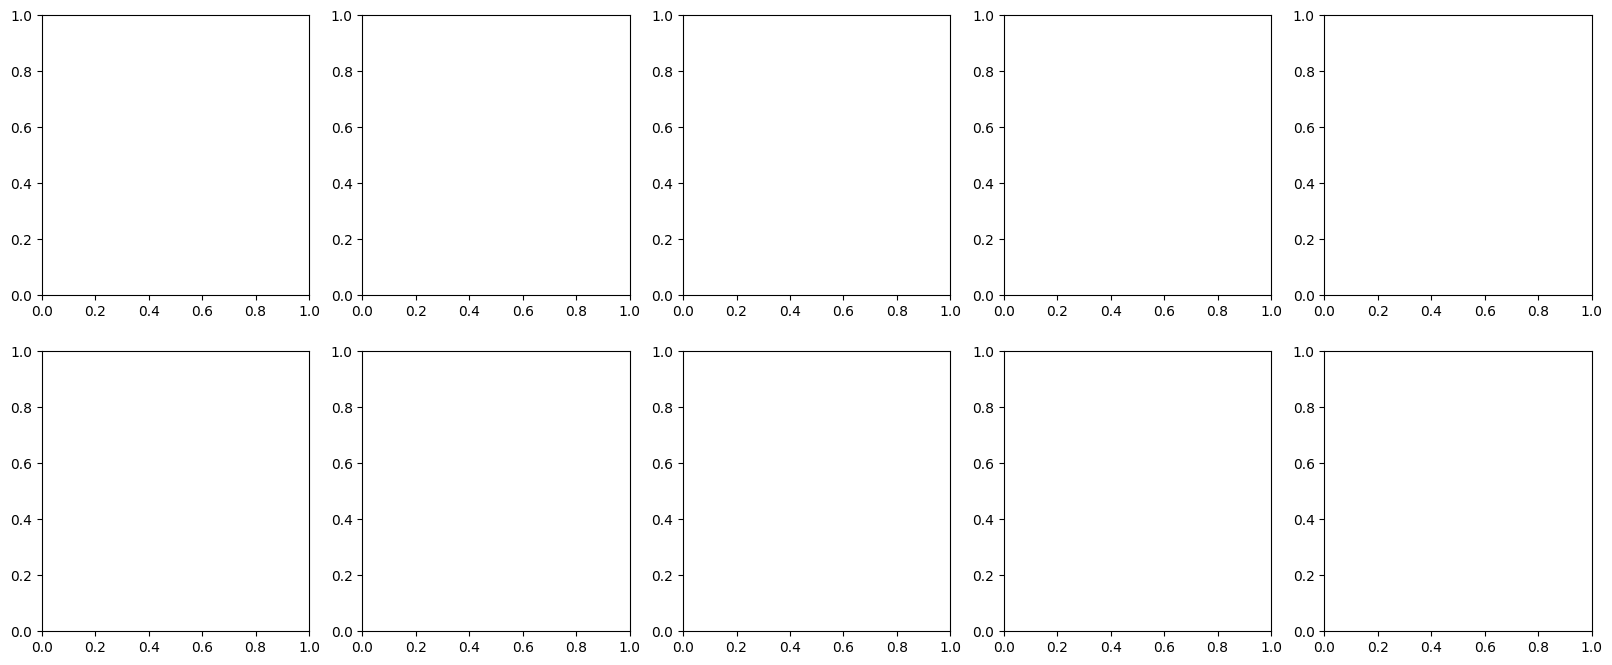

In [11]:
# Generate 10 random numbers between 0 and 1024
import random
random.seed(0)
random_neurons = random.sample(range(0, 1024), 10)

# Get random directory

for layer_num in tqdm(range(0, 10)):
    load_directory = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/max_min_imgs/layer_{layer_num}'
    save_directory = '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/figures/random_figures'

    name = 'max'
    for neuron_idx in random_neurons:
        # Create a new figure for each neuron
        fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust the size as needed

        # Flatten the array of axes for easy iterating
        axs = axs.flatten()

        # Iterate through images for neuron
        for img_idx, ax in enumerate(axs): 
            # Load image
            max_img_path = os.path.join(load_directory, f'neuron_{neuron_idx}_{name}_{img_idx}.svg')
            max_img = plt.imread(max_img_path)

            # Display image
            ax.imshow(max_img)
            ax.axis('off')  # Turn off axis

        # Add a master title for the figure
        plt.suptitle(f'Neuron {neuron_idx} - Top 10 Images', fontsize=16)

        # Adjust layout and display the figure
        plt.tight_layout()
        plt.subplots_adjust(top=1)  # Adjust the top so that the suptitle does not overlap with the subplots

        # Save the figure as an SVG file
        save_path = os.path.join(save_directory, f'{name}-neuron_{neuron_idx}_10_images.svg')
        plt.savefig(save_path, format='svg')
        save_path = os.path.join(save_directory, f'{name}-neuron_{neuron_idx}_10_images.png')
        plt.savefig(save_path, format='png')

        # Close the figure to free memory
        plt.close(fig)
        